In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
import sys
sys.path.append('../')

from intersections_and_roads import *
from shapely.geometry import *
import ast
from search import *
import pickle

In [3]:
intersections_points = gpd.read_file('../sf_data/street_intersections.geojson')
street_centerlines = gpd.read_file('../sf_data/San_Francisco_Basemap_Street_Centerlines.geojson')

In [4]:
street_centerlines['ToNode'] = street_centerlines['t_node_cnn'].astype(np.int32)
street_centerlines['FromNode'] = street_centerlines['f_node_cnn'].astype(np.int32)
street_centerlines['id'] =  street_centerlines['cnn'].apply(lambda x: int(float(x)))
# Get the direction
street_centerlines['Direction'] = street_centerlines['oneway'].apply(lambda x: 0 if x == 'B' else 1 if x == 'F' else -1)
street_centerlines.head(2)

accepted classcode         cnn   cnntext district f_node_cnn  \
0        N         0  15145000.0  15145000     None   26132000   
1        Y         0  11305001.0  11305001     None   26255000   

                                            geometry jurisdicti    layer  \
0  LINESTRING (-122.4469424451799 37.757228921523...       None  PRIVATE   
1  LINESTRING (-122.4479152656158 37.757589498018...        DPW    UPROW   

  lf_fadd    ...    st_type         street      street_gc         streetname  \
0     0.0    ...         CT          CROWN          CROWN           CROWN CT   
1     1.0    ...        AVE  SAINT GERMAIN  SAINT GERMAIN  SAINT GERMAIN AVE   

  t_node_cnn zip_code    ToNode  FromNode        id Direction  
0   54223000    94114  54223000  26132000  15145000         0  
1   54224000    94114  54224000  26255000  11305001         0  

[2 rows x 26 columns]

In [5]:
intersections_points['NodeNumber'] = intersections_points['cnntext'].apply(lambda x: int(float(x)))
intersections_points['id'] = intersections_points['cnntext']
intersections_points.head(2)

cnn   cnntext                                      geometry st_name  \
0  23730000  23730000  POINT (-122.4054541718919 37.75433723137436)    UTAH   
1  22141000  22141000  POINT (-122.4397477601416 37.73236806396732)   JOOST   

  st_type  NodeNumber        id  
0      ST    23730000  23730000  
1     AVE    22141000  22141000

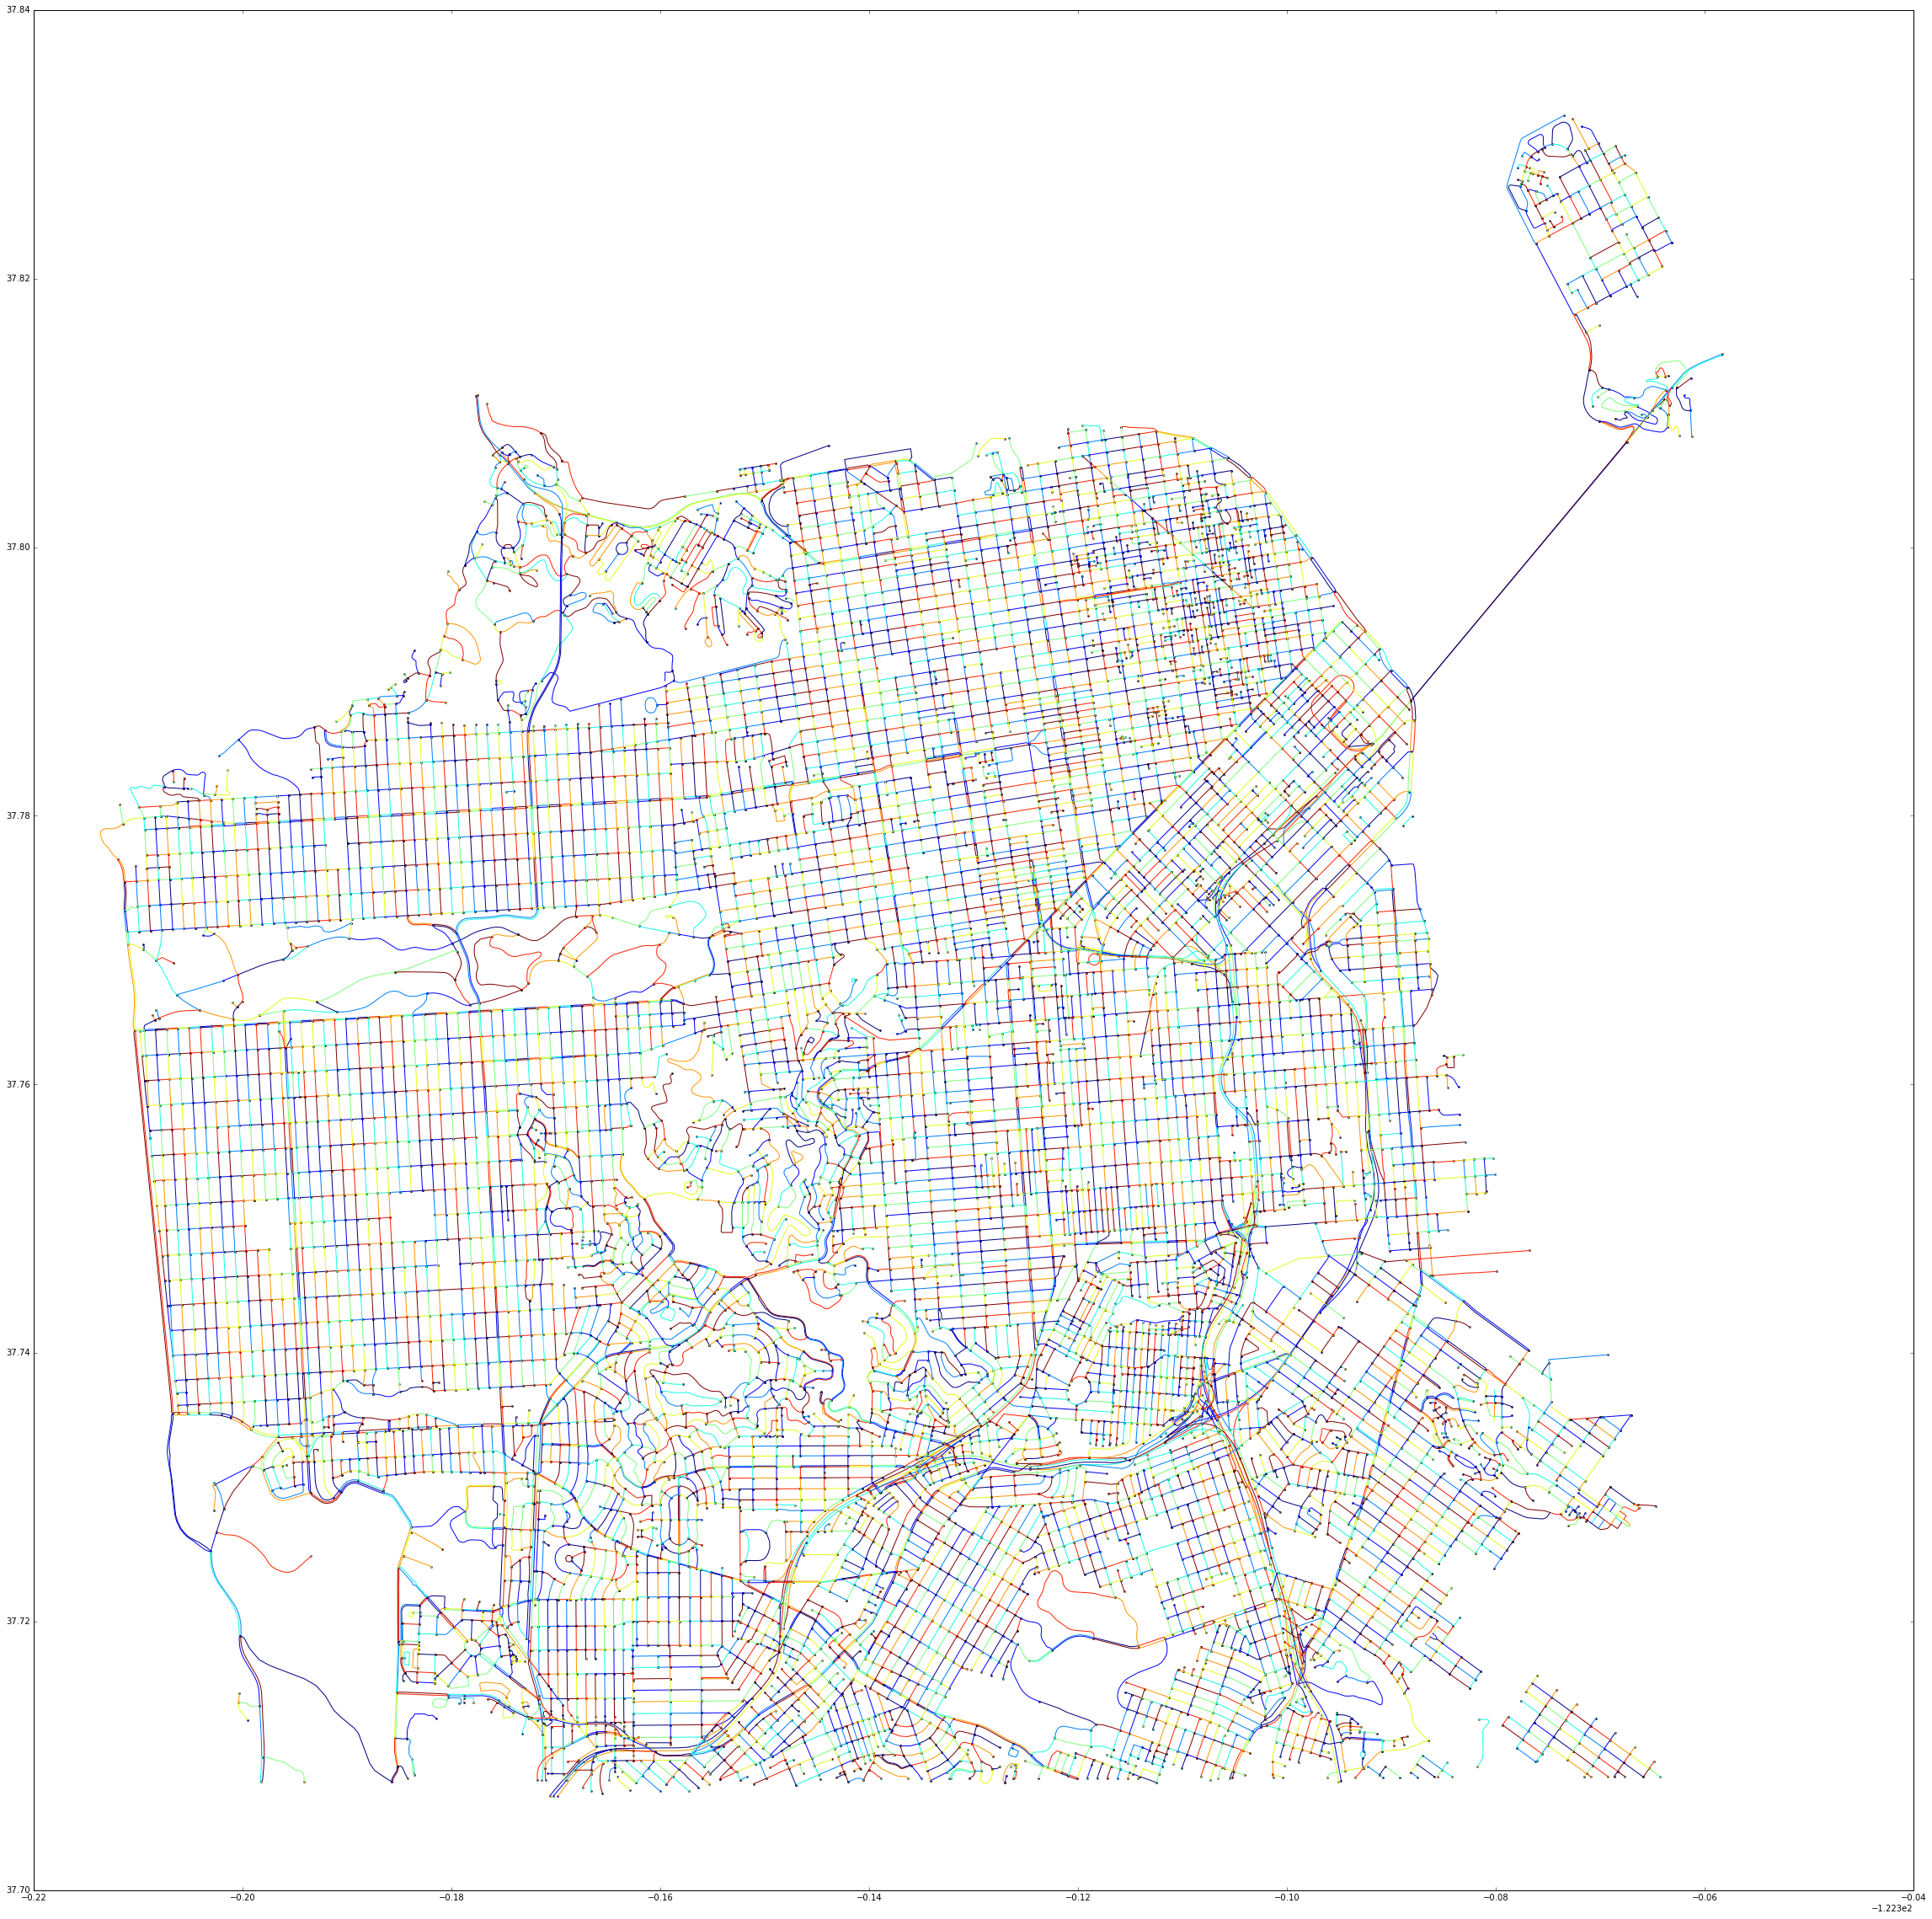

In [5]:
fig, ax = plt.subplots(1,1, figsize=(40,40))
intersections_points.plot(ax=ax)
street_centerlines.plot(ax=ax)

In [6]:
intersection_graph, connection_dict = build_intersection_graph(intersections_points, street_centerlines)

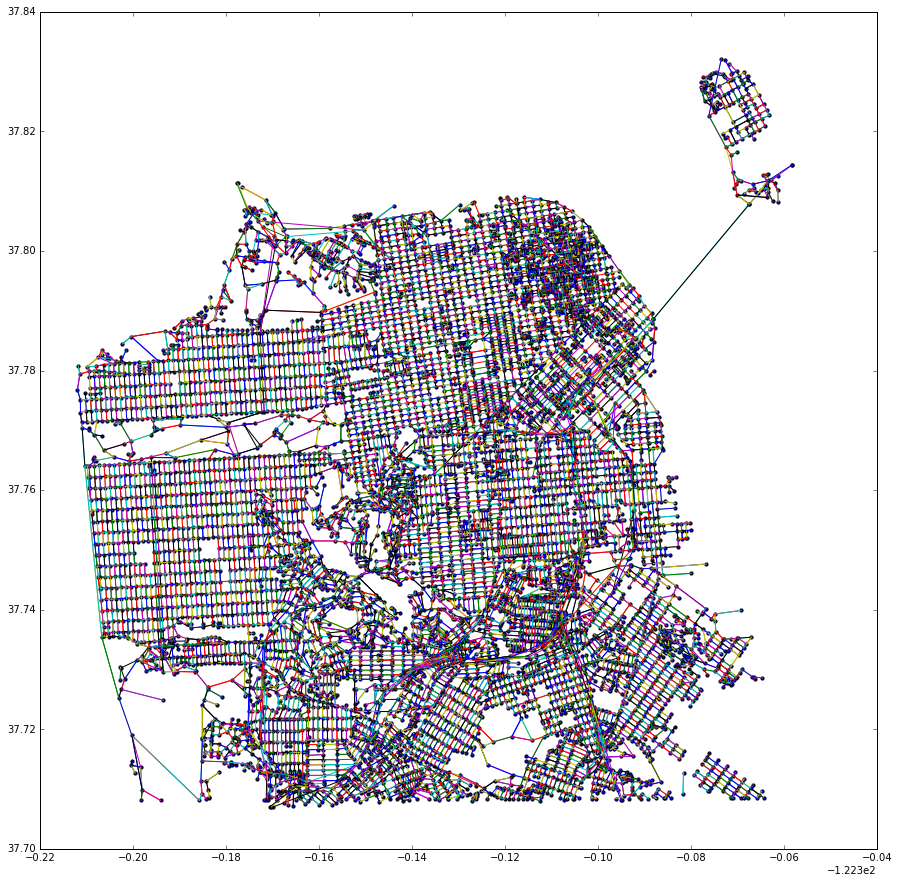

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15, 15))

xs = [intersection_graph[key].get_x_y()[0] for key in intersection_graph]
ys = [intersection_graph[key].get_x_y()[1] for key in intersection_graph]

for key in intersection_graph:
    node = intersection_graph[key]
    for connection in node.get_connections():
        child = connection_dict[connection]
        line_x = [child.get_source(intersection_graph).get_x_y()[0], child.get_target(intersection_graph).get_x_y()[0]]
        line_y = [child.get_source(intersection_graph).get_x_y()[1], child.get_target(intersection_graph).get_x_y()[1]]
        ax.plot(line_x, line_y)

ax.scatter(xs, ys, s=10)
plt.show()

In [8]:
# randomly select a start and an end point on the graph for test
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [9]:
end.get_connections()

{600000, 601000, 3783000, 3784000}

In [10]:
# search the graph
route = a_star_search(start, end, intersection_graph, connection_dict, get_road_cost)
# plot_graph(intersection_graph, connection_dict, [route['nodes']], [])

In [ ]:
# plot_graph(intersection_graph, connection_dict, [route['nodes']])

In [31]:
with open('san_fran_intersection_graph', 'wb') as f:
    pickle.dump(intersection_graph, f)
with open('san_fran_connection_dic', 'wb') as f:
    pickle.dump(connection_dict, f)

In [7]:
# select a set of random starting points
p1 = intersection_graph[np.random.choice(intersection_graph.keys())]
p2 = intersection_graph[np.random.choice(intersection_graph.keys())]
p3 = intersection_graph[np.random.choice(intersection_graph.keys())]
p4 = intersection_graph[np.random.choice(intersection_graph.keys())]
p5 = intersection_graph[np.random.choice(intersection_graph.keys())]

starting_points = [p1,p2,p3,p4]

best_centroid, best_cost, k_points = k_beam_search(5, intersection_graph, connection_dict, get_road_cost, euclidean_heuristic, starting_points=starting_points)

iteration  0 best cost 0.0797540370046
iteration  1 best cost 0.0790147170433
iteration  2 best cost 0.0778151740447
iteration  3 best cost 0.0761229617728
iteration  4 best cost 0.0718767545911
iteration  5 best cost 0.0703857832705


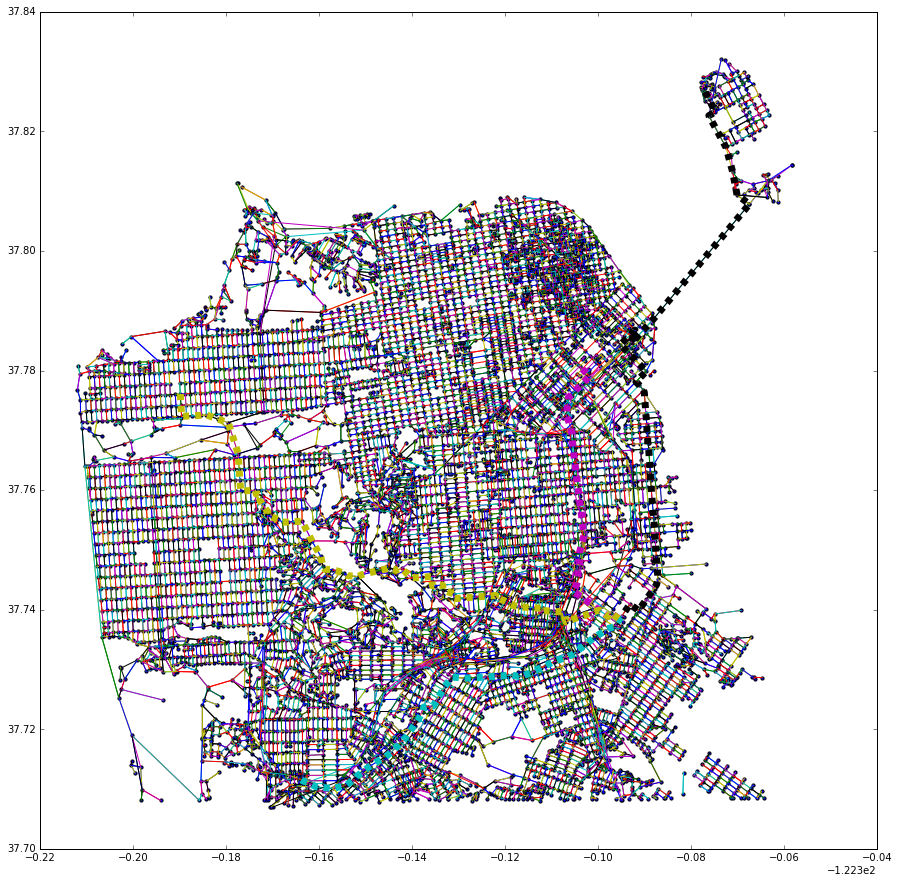

In [8]:
fig, ax = plt.subplots(1,1, figsize=(15, 15))
routes, connections = get_routes_to_centroid(best_centroid, starting_points, k_points, intersection_graph, connection_dict)
plot_local_search_graph(best_centroid, starting_points, k_points, intersection_graph, connection_dict, routes, ax=ax)

In [26]:
starting_points = [p1,p2,p3,p4]

In [28]:
starting_points.append(best_centroid)
starting_points.append(k_points)

In [29]:
with open('san_fran_4_points_centroid_and_k_points', 'wb') as f:
    pickle.dump(starting_points, f)

In [30]:
with open('san_fran_4_points_centroid_and_k_points', 'rb') as f:
    print pickle.load(f)

[<intersections_and_roads.node instance at 0x15f6f5680>, <intersections_and_roads.node instance at 0x15f6f5a70>, <intersections_and_roads.node instance at 0x15ebf6170>, <intersections_and_roads.node instance at 0x15ebf61b8>, <intersections_and_roads.node instance at 0x15ebf6200>, <intersections_and_roads.node instance at 0x15ebf6200>, array([<intersections_and_roads.node instance at 0x15ebf6248>,
       <intersections_and_roads.node instance at 0x15ebf6248>,
       <intersections_and_roads.node instance at 0x15ebf6290>,
       <intersections_and_roads.node instance at 0x15ebf6290>,
       <intersections_and_roads.node instance at 0x15ebf62d8>], dtype=object)]
